In [2]:
import pandas as pd
import numpy as np
import kagglehub
import shutil
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_curve, 
    roc_auc_score
)
import matplotlib.pyplot as plt

In [3]:
# 1. Load Dataset
path = kagglehub.dataset_download("datasnaek/chess")

print("Path to dataset files:", path)

shutil.move(path, "./Raw_Data")

100%|██████████| 2.77M/2.77M [00:00<00:00, 21.3MB/s]

Extracting model files...


Path to dataset files: C:\Users\cjmij\.cache\kagglehub\datasets\datasnaek\chess\versions\1


'./Raw_Data\\1'

In [4]:
df = pd.read_csv("./Raw_Data/games.csv")
df.info()
df.describe()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20058 entries, 0 to 20057
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              20058 non-null  object 
 1   rated           20058 non-null  bool   
 2   created_at      20058 non-null  float64
 3   last_move_at    20058 non-null  float64
 4   turns           20058 non-null  int64  
 5   victory_status  20058 non-null  object 
 6   winner          20058 non-null  object 
 7   increment_code  20058 non-null  object 
 8   white_id        20058 non-null  object 
 9   white_rating    20058 non-null  int64  
 10  black_id        20058 non-null  object 
 11  black_rating    20058 non-null  int64  
 12  moves           20058 non-null  object 
 13  opening_eco     20058 non-null  object 
 14  opening_name    20058 non-null  object 
 15  opening_ply     20058 non-null  int64  
dtypes: bool(1), float64(2), int64(4), object(9)
memory usage: 2.3+ MB


,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3
3,kWKvrqYL,True,1.504110e+12,1.504110e+12,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3
4,9tXo1AUZ,True,1.504030e+12,1.504030e+12,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5


Classification Report:
               precision    recall  f1-score   support

Black Win (0)       0.67      0.60      0.63      1784
White Win (1)       0.67      0.73      0.70      1959

     accuracy                           0.67      3743
    macro avg       0.67      0.67      0.67      3743
 weighted avg       0.67      0.67      0.67      3743

Confusion Matrix:
[[1073  711]
 [ 528 1431]]
AUC: 0.7342814696800097


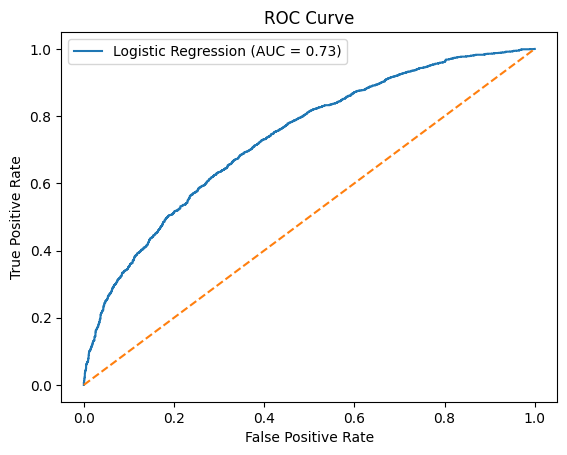

In [5]:
# ------------------------------------------------------------
# 2. Basic Cleaning & Filtering
# ------------------------------------------------------------
# Remove duplicates if present
df.drop_duplicates(inplace=True)

# Remove rows with missing values in critical columns
# (E.g., player ratings or outcome)
df.dropna(subset=['white_rating', 'black_rating', 'winner'], inplace=True)

# Exclude draws (only keep 'white' or 'black' outcomes)
df = df[df['winner'].isin(['white', 'black'])]

# ------------------------------------------------------------
# 3. Construct Features (Rating Difference, Elo Bins, etc.)
# ------------------------------------------------------------
# Calculate rating difference: white_rating - black_rating
df['rating_diff'] = df['white_rating'] - df['black_rating']

# Count the number of moves (if your data includes move notation)
# Some Lichess datasets store moves in a single string (e.g. PGN).
# For example, if moves are in a column called 'moves':
df['num_moves'] = df['moves'].apply(lambda x: len(x.split()) if pd.notna(x) else np.nan)

# Drop rows where we cannot extract the number of moves
df.dropna(subset=['num_moves'], inplace=True)

# Create a binary outcome: 1 if White wins, 0 if Black wins
df['white_win'] = df['winner'].apply(lambda x: 1 if x == 'white' else 0)

# ------------------------------------------------------------
# 4. (Optional) Bin Overall Elo for Sub-analyses
# ------------------------------------------------------------
# If you want to replicate the class-based approach, compute the average rating per game:
df['avg_rating'] = (df['white_rating'] + df['black_rating']) / 2

# Example binning based on the USCF categories from the paper
bins = [0, 999, 1199, 1399, 1599, 1799, 1999, 2199, 2399, 3000]
labels = ['Class J-F','Class E','Class D','Class C','Class B','Class A','Expert','Master','Senior Master']
df['rating_class'] = pd.cut(df['avg_rating'], bins=bins, labels=labels, include_lowest=True)

# ------------------------------------------------------------
# 5. Train/Test Split
# ------------------------------------------------------------
features = ['rating_diff', 'num_moves']  # as in the paper
X = df[features]
y = df['white_win']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# (Optional) Feature Scaling if you prefer standardization for logistic regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ------------------------------------------------------------
# 6. Fit Logistic Regression
# ------------------------------------------------------------
model = LogisticRegression(
    solver='lbfgs', 
    max_iter=1000,
    random_state=42
)
model.fit(X_train_scaled, y_train)

# ------------------------------------------------------------
# 7. Evaluate the Model
# ------------------------------------------------------------
y_pred = model.predict(X_test_scaled)

# Classification Report (includes precision, recall, f1-score)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Black Win (0)', 'White Win (1)']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Accuracy, ROC, and AUC
y_proba = model.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)
print("AUC:", auc_score)

plt.figure()
plt.plot(fpr, tpr, label=f"Logistic Regression (AUC = {auc_score:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--')  # reference line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# ------------------------------------------------------------
# 8. (Optional) Evaluate by Elo Class
# ------------------------------------------------------------
# For example, you could loop through each rating class and train/evaluate
# a separate model or subset your train/test sets for each bin to replicate
# the approach from the paper.


In [6]:
# Assuming your trained logistic regression model is stored in 'model'
joblib.dump(model, 'logistic_chess_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']